In [2]:
import pandas as pd
import numpy as np
import simpy
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

c:\Users\giuli\Repositories\lamp\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- Carica dataset ---
df = pd.read_csv('dataset.csv')
# Rename column to remove new line
df.columns = [col.replace("\n", " ") for col in df.columns]
print(df.columns.tolist())
df


['Id', 'Mese', 'Id Equipaggio', 'UPL', 'Classe', 'Valore medio della merce consegnata in un giro [€/giro]', '# giorni lavorati nel mese', '# clienti  serviti nel mese', 'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]', '# consegne ripianificate per problemi nel TRASPORTO', '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)', '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)', '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)', '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)', 'Unnamed: 14']


In [ ]:
import numpy as np
import pandas as pd

# Assumptions
avg_crew_size = 3  # assume each crew has 3 people on average

# NumeroRisorse: Assume = # giorni lavorati nel mese * avg_crew_size
df['NumeroRisorse'] = pd.to_numeric(df.get('# giorni lavorati nel mese', 0), errors='coerce').fillna(0) * avg_crew_size

# NumeroConsegneEffettuate: from '# clienti  serviti nel mese'
df['NumeroConsegneEffettuate'] = pd.to_numeric(df.get('# clienti  serviti nel mese', 0), errors='coerce').fillna(0)

# Clean numeric columns helper
def clean_numeric_column(col_name):
    if col_name in df.columns:
        return (
            df[col_name].astype(str)
            .str.replace(',', '.', regex=False)
            .str.extract(r'([-+]?\d*\.?\d+)')[0]
            .astype(float)
            .fillna(0)
        )
    else:
        return pd.Series([0]*len(df), index=df.index)

valore_merce = clean_numeric_column('Valore medio della merce consegnata in un giro [€/giro]')
delta_min = clean_numeric_column('Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]')

# LeadTimeEfficiency: valore_merce / (1 + abs(delta_min))
df['LeadTimeEfficiency'] = valore_merce / (1 + delta_min.abs())

# PercentualeFlessibili: no columns available, so assume it as a random example fixed or synthetic metric
# e.g. 10% flexibility assumed
df['PercentualeFlessibili'] = 10  # 10% assumed flexibility

# TotaleRiprogrammazioni: sum all "ripianificate" columns available
rip_cols = [
    '# consegne ripianificate per problemi nel TRASPORTO',
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)',
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)',
    '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)',
    '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)'
]

df['TotaleRiprogrammazioni'] = sum(
    pd.to_numeric(df.get(col, 0), errors='coerce').fillna(0)
    for col in rip_cols
)

# Calcola RitardoMedioConsegna = TotaleRiprogrammazioni / NumeroConsegneEffettuate
num_clienti = df['NumeroConsegneEffettuate'].replace(0, np.nan)
df['RitardoMedioConsegna'] = (df['TotaleRiprogrammazioni'] / num_clienti).fillna(0)

# CustomerSatisfaction proxy: 1 - (ripianificate per cause cliente / clienti serviti)
cause_clienti = pd.to_numeric(df.get('# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)', 0), errors='coerce').fillna(0)
df['CustomerSatisfaction'] = ((1 - (cause_clienti / num_clienti)).fillna(0)) * 100

# PercentualeConsegneRiprogrammate = TotaleRiprogrammazioni / clienti serviti * 100
df['PercentualeConsegneRiprogrammate'] = ((df['TotaleRiprogrammazioni'] / num_clienti).fillna(0)) * 100

# KPIs columns list
kpi_columns = [
    'NumeroRisorse',
    'NumeroConsegneEffettuate',
    'LeadTimeEfficiency',
    'PercentualeFlessibili',
    'RitardoMedioConsegna',
    'CustomerSatisfaction',
    'PercentualeConsegneRiprogrammate'
]

# Optionally select KPIs only
df_kpis = df[kpi_columns]


In [17]:
df_kpis

,NumeroRisorse,NumeroConsegneEffettuate,LeadTimeEfficiency,PercentualeFlessibili,RitardoMedioConsegna,CustomerSatisfaction,PercentualeConsegneRiprogrammate
0,72,71.0,0.692829,10,0.070423,95.774648,7.042254
1,51,55.0,0.977100,10,0.090909,90.909091,9.090909
2,24,14.0,0.196274,10,0.285714,78.571429,28.571429
3,45,31.0,0.165435,10,0.096774,93.548387,9.677419
4,75,97.0,0.769519,10,0.164948,96.907216,16.494845
...,...,...,...,...,...,...,...
1478,66,65.0,0.416378,10,0.246154,95.384615,24.615385
1479,63,70.0,0.520171,10,0.057143,95.714286,5.714286
1480,57,60.0,0.335258,10,0.083333,96.666667,8.333333
1481,54,62.0,0.233095,10,0.161290,96.774194,16.129032


In [18]:
# Copy the original DataFrame so you don't modify it in place
df_to_be = df.copy()

# Dictionary with percentual changes (e.g., 0.10 means +10%, -0.40 means -40%)
kpi_improvements = {
    'Valore_medio_della_merce_consegnata_in_un_giro_€_giro': 0.05,
    'n_giorni_lavorati_nel_mese': 0.0,
    'n_clienti_serviti_nel_mese': 0.10,
    'Delta_orario_di_fine_montaggio_EFFETTIVO_-_orario_di_fine_montaggio_CONCORDATO__min': -0.40,
    'n_consegne_ripianificate_per_problemi_nel_TRASPORTO': -0.50,
    'n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_1_camere_armadio_e_camerette': -0.30,
    'n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_2_cucine_e_soggiorni': -0.30,
    'n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_3_arredo_bagno_tavoli_sedie': -0.25,
    'n_consegne_ripianificate_per_CAUSE_LATO_CLIENTE_FINALE_assenza_e_AZIENDA_COMMITTENTE_es_pe': -0.15
}

# Apply the improvements by multiplying each relevant column by (1 + improvement)
for kpi, change in kpi_improvements.items():
    if kpi in df_to_be.columns:
        df_to_be[kpi] = df_to_be[kpi] * (1 + change)



In [21]:


# Mapping of "short" KPI names to actual df_to_be columns:
mapping = {
    'NumeroRisorse': 'NumeroRisorse',  # if exists; else fallback to NaN
    'n_clienti_serviti_nel_mese': '# clienti  serviti nel mese',
    'Valore_medio_della_merce_consegnata_in_un_giro_€_giro': 'Valore medio della merce consegnata in un giro [€/giro]',
    'Delta_orario_di_fine_montaggio_EFFETTIVO_-_orario_di_fine_montaggio_CONCORDATO__min': 'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]',
    'n_consegne_ripianificate_per_problemi_nel_TRASPORTO': '# consegne ripianificate per problemi nel TRASPORTO',
    'n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_1_camere_armadio_e_camerette': '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)',
    'n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_2_cucine_e_soggiorni': '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)',
    'n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_3_arredo_bagno_tavoli_sedie': '# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie)',
    'n_consegne_ripianificate_per_CAUSE_LATO_CLIENTE_FINALE_assenza_e_AZIENDA_COMMITTENTE_es_pe': '# consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti)',
    # Add more mappings if needed
}

# --- Ricalcolo KPI To Be ---

# NumeroRisorse: if exists, else NaN
if mapping['NumeroRisorse'] in df_to_be.columns:
    df_to_be['NumeroRisorse'] = df_to_be[mapping['NumeroRisorse']]
else:
    df_to_be['NumeroRisorse'] = np.nan

# NumeroConsegneEffettuate from '# clienti  serviti nel mese'
col_clienti = mapping['n_clienti_serviti_nel_mese']
if col_clienti in df_to_be.columns:
    df_to_be['NumeroConsegneEffettuate'] = pd.to_numeric(df_to_be[col_clienti], errors='coerce').fillna(0)
else:
    df_to_be['NumeroConsegneEffettuate'] = 0

# LeadTimeEfficiency: valore / (1 + abs(delta))
col_valore = mapping['Valore_medio_della_merce_consegnata_in_un_giro_€_giro']
col_delta = mapping['Delta_orario_di_fine_montaggio_EFFETTIVO_-_orario_di_fine_montaggio_CONCORDATO__min']

valore = pd.Series(0, index=df_to_be.index)
delta = pd.Series(0, index=df_to_be.index)

if col_valore in df_to_be.columns:
    valore = pd.to_numeric(df_to_be[col_valore], errors='coerce').fillna(0)
if col_delta in df_to_be.columns:
    delta = pd.to_numeric(df_to_be[col_delta], errors='coerce').fillna(0).abs()

df_to_be['LeadTimeEfficiency'] = valore / (1 + delta)

# PercentualeFlessibili: check columns and avoid division by zero
if 'NumeroEquipaggiJolly' in df_to_be.columns and 'NumeroTotaleEquipaggi' in df_to_be.columns:
    jolly = pd.to_numeric(df_to_be['NumeroEquipaggiJolly'], errors='coerce').fillna(0)
    totale = pd.to_numeric(df_to_be['NumeroTotaleEquipaggi'], errors='coerce').replace(0, np.nan)
    df_to_be['PercentualeFlessibili'] = (jolly / totale * 100).fillna(0)
else:
    df_to_be['PercentualeFlessibili'] = np.nan

# TotaleRiprogrammazioni: sum of riprogrammazione columns with fallback 0
rip_cols = [
    mapping['n_consegne_ripianificate_per_problemi_nel_TRASPORTO'],
    mapping['n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_1_camere_armadio_e_camerette'],
    mapping['n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_2_cucine_e_soggiorni'],
    mapping['n_consegne_ripianificate_per_problemi_nel_MONTAGGIO_di_TIPO_3_arredo_bagno_tavoli_sedie'],
    mapping['n_consegne_ripianificate_per_CAUSE_LATO_CLIENTE_FINALE_assenza_e_AZIENDA_COMMITTENTE_es_pe']
]

tot_rip = pd.Series(0, index=df_to_be.index)
for col in rip_cols:
    if col in df_to_be.columns:
        tot_rip += pd.to_numeric(df_to_be[col], errors='coerce').fillna(0)
df_to_be['TotaleRiprogrammazioni'] = tot_rip

# Avoid division by zero for RitardoMedioConsegna and others
num_clienti = df_to_be['NumeroConsegneEffettuate'].replace(0, np.nan)

cause_col = mapping['n_consegne_ripianificate_per_CAUSE_LATO_CLIENTE_FINALE_assenza_e_AZIENDA_COMMITTENTE_es_pe']
cause_clienti = pd.Series(0, index=df_to_be.index)
if cause_col in df_to_be.columns:
    cause_clienti = pd.to_numeric(df_to_be[cause_col], errors='coerce').fillna(0)

df_to_be['RitardoMedioConsegna'] = (df_to_be['TotaleRiprogrammazioni'] / num_clienti).fillna(0)
df_to_be['CustomerSatisfaction'] = ((1 - (cause_clienti / num_clienti)).fillna(0)) * 100
df_to_be['PercentualeConsegneRiprogrammate'] = ((df_to_be['TotaleRiprogrammazioni'] / num_clienti).fillna(0)) * 100

# --- Delta KPI ---
# Assuming kpi_columns defined and df, df_to_be have same indices and columns
delta_kpi = df_to_be[kpi_columns] - df[kpi_columns]
normalized_delta_kpi = delta_kpi / df[kpi_columns].replace(0, np.nan)


In [22]:

# --- AHP ---
print("\n--- AHP: confronti a coppie tra KPI ---")
n = len(kpi_columns)
ahp_matrix = np.ones((n, n))

for i in range(n):
    for j in range(i+1, n):
        while True:
            try:
                val = float(input(f"Quanto è più importante '{kpi_columns[i]}' rispetto a '{kpi_columns[j]}'? [1-9]: "))
                if val < 1 or val > 9:
                    print("Inserisci un valore tra 1 e 9.")
                    continue
                ahp_matrix[i, j] = val
                ahp_matrix[j, i] = 1 / val
                break
            except ValueError:
                print("Inserisci un numero valido.")

eigvals, eigvecs = np.linalg.eig(ahp_matrix)
max_index = np.argmax(eigvals.real)
ahp_weights = eigvecs[:, max_index].real
ahp_weights /= ahp_weights.sum()


--- AHP: confronti a coppie tra KPI ---



--- AHP: confronti a coppie tra KPI ---
Inserisci un valore tra 1 e 9.
Inserisci un valore tra 1 e 9.
0
Empty DataFrame
Columns: [Id, Mese, Id Equipaggio, UPL, Classe, Valore medio della merce consegnata in un giro [€/giro], # giorni lavorati nel mese, # clienti  serviti nel mese, Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min], # consegne ripianificate per problemi nel TRASPORTO, # consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette), # consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni), # consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, sedie), # consegne ripianificate per CAUSE LATO CLIENTE FINALE (assenza) e AZIENDA COMMITTENTE (es. pezzi mancanti), Unnamed: 14, NumeroRisorse, NumeroConsegneEffettuate, LeadTimeEfficiency, PercentualeFlessibili, TotaleRiprogrammazioni, RitardoMedioConsegna, CustomerSatisfaction, PercentualeConsegneRiprog

 99%|===================| 1471/1483 [00:44<00:00]        


--- Risultati sintetici ---
                                KPI  Delta (%)  AHP Weight  SHAP Weight  \
0                     NumeroRisorse        0.0    0.367280     0.479688   
1          NumeroConsegneEffettuate        0.0    0.181072     0.124312   
3              RitardoMedioConsegna        0.0    0.078517     0.100104   
4              CustomerSatisfaction        0.0    0.062134     0.196054   
5  PercentualeConsegneRiprogrammate        0.0    0.043420     0.099842   
2             PercentualeFlessibili        NaN    0.065125     0.000000   

   Weighted Contribution (AHP)  Weighted Contribution (SHAP)  \
0                          0.0                           0.0   
1                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   
5                          0.0                           0.0   
2                          NaN                           NaN 

 99%|===================| 1465/1483 [00:39<00:00]        

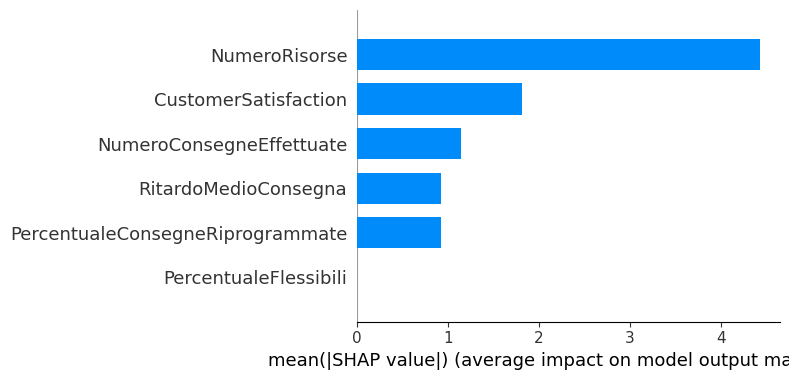

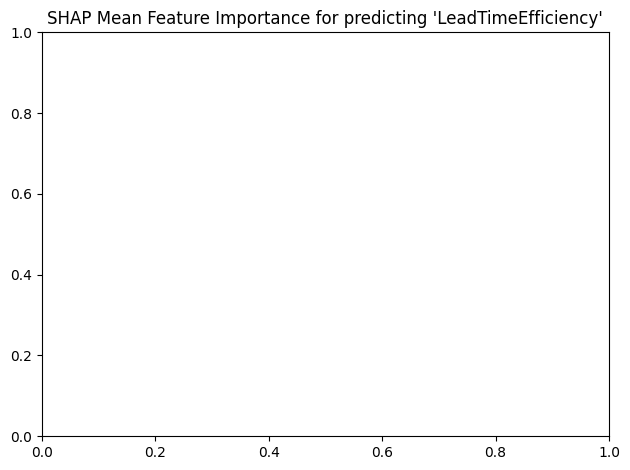

c:\Users\giuli\Repositories\lamp\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


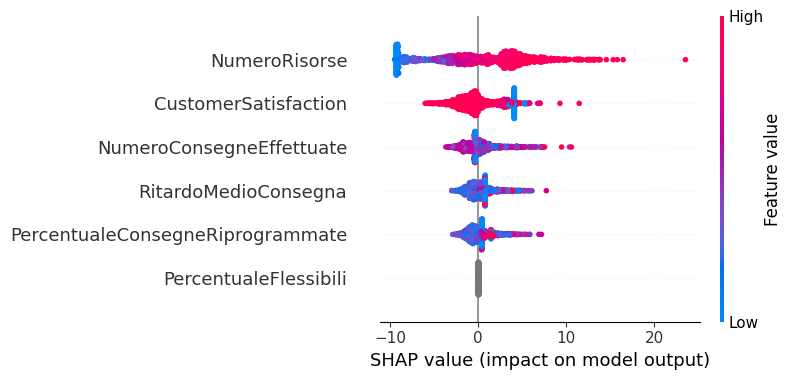

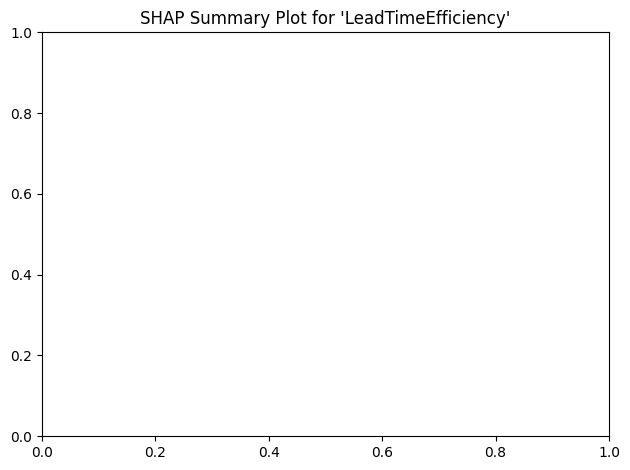


--- SHAP Weights ---
NumeroRisorse                       0.479688
CustomerSatisfaction                0.196054
NumeroConsegneEffettuate            0.124312
RitardoMedioConsegna                0.100104
PercentualeConsegneRiprogrammate    0.099842
PercentualeFlessibili               0.000000
dtype: float64


In [25]:


# --- AHP ---
print("\n--- AHP: confronti a coppie tra KPI ---")
n = len(kpi_columns)
ahp_matrix = np.ones((n, n))

for i in range(n):
    for j in range(i+1, n):
        while True:
            try:
                val = float(input(f"Quanto è più importante '{kpi_columns[i]}' rispetto a '{kpi_columns[j]}'? [1-9]: "))
                if val < 1 or val > 9:
                    print("Inserisci un valore tra 1 e 9.")
                    continue
                ahp_matrix[i, j] = val
                ahp_matrix[j, i] = 1 / val
                break
            except ValueError:
                print("Inserisci un numero valido.")

eigvals, eigvecs = np.linalg.eig(ahp_matrix)
max_index = np.argmax(eigvals.real)
ahp_weights = eigvecs[:, max_index].real
ahp_weights /= ahp_weights.sum()

# Fill missing numeric values with column means
df_to_be.fillna(df_to_be.mean(numeric_only=True), inplace=True)

print(df_to_be['LeadTimeEfficiency'].isna().sum())
print(df_to_be[df_to_be['LeadTimeEfficiency'].isna()])

# --- SHAP analysis ---
X_shap = df_to_be[kpi_columns].drop(columns=['LeadTimeEfficiency'])
y_shap = df_to_be['LeadTimeEfficiency']

model = RandomForestRegressor(random_state=42)
model.fit(X_shap, y_shap)

explainer = shap.Explainer(model, X_shap)
shap_values = explainer(X_shap, check_additivity=False)

shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
shap_weights = shap_mean_importance / shap_mean_importance.sum()

# Escludo 'LeadTimeEfficiency' da tutte le strutture per coerenza
kpi_core_columns = [col for col in kpi_columns if col != 'LeadTimeEfficiency']

# Prendo delta medi solo per KPI core
delta_core = normalized_delta_kpi[kpi_core_columns].mean(axis=0).values * 100

# Ahp weights corrispondenti ai KPI core (filtrati)
ahp_core = ahp_weights[[kpi_columns.index(col) for col in kpi_core_columns]]

# Costruisco DataFrame sintetico
summary_df = pd.DataFrame({
    'KPI': kpi_core_columns,
    'Delta (%)': delta_core,
    'AHP Weight': ahp_core,
    'SHAP Weight': shap_weights
})

# Calcolo contributi pesati
summary_df['Weighted Contribution (AHP)'] = summary_df['Delta (%)'] * summary_df['AHP Weight']
summary_df['Weighted Contribution (SHAP)'] = summary_df['Delta (%)'] * summary_df['SHAP Weight']

# Normalizzo i contributi per confronto visivo
summary_df['Weighted Contribution (AHP) Normalized'] = summary_df['Weighted Contribution (AHP)'] / summary_df['Weighted Contribution (AHP)'].max()
summary_df['Weighted Contribution (SHAP) Normalized'] = summary_df['Weighted Contribution (SHAP)'] / summary_df['Weighted Contribution (SHAP)'].max()

print("\n--- Risultati sintetici ---")
print(summary_df.sort_values('Weighted Contribution (AHP)', ascending=False))

def shap_kpi_analysis(df, kpi_columns, target_kpi, max_display=20, random_state=42):
    """
    Performs SHAP analysis to evaluate the importance of each KPI in predicting the target KPI.
    
    Parameters:
    - df: DataFrame with KPI data
    - kpi_columns: list of KPI column names (including target_kpi)
    - target_kpi: str, name of the KPI column to explain
    - max_display: int, max number of features to display in SHAP plots
    - random_state: int, random seed for reproducibility
    
    Returns:
    - shap_weights: normalized SHAP weights as pandas Series indexed by KPI names (excluding target_kpi)
    - shap_values, explainer, model: SHAP objects for further analysis if needed
    """
    # Ensure target_kpi is in the list
    assert target_kpi in kpi_columns, f"Target KPI '{target_kpi}' must be in kpi_columns"

    # Features exclude the target KPI
    feature_cols = [col for col in kpi_columns if col != target_kpi]

    # Prepare X and y
    X = df[feature_cols]
    y = df[target_kpi]

    # Fit a regression model
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X, y)

    # SHAP explainer & values
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X, check_additivity=False)

    # Mean absolute SHAP values = feature importance
    shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
    shap_weights = shap_mean_importance / shap_mean_importance.sum()
    shap_weights = pd.Series(shap_weights, index=feature_cols).sort_values(ascending=False)

    # Plot mean SHAP importance (bar)
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=max_display)
    plt.title(f"SHAP Mean Feature Importance for predicting '{target_kpi}'")
    plt.tight_layout()
    plt.show()

    # Plot detailed SHAP summary (dot) plot
    plt.figure(figsize=(12,8))
    shap.summary_plot(shap_values, X, max_display=max_display)
    plt.title(f"SHAP Summary Plot for '{target_kpi}'")
    plt.tight_layout()
    plt.show()

    return shap_weights, shap_values, explainer, model

shap_weights, shap_values, explainer, model = shap_kpi_analysis(df_to_be, kpi_columns, 'LeadTimeEfficiency')

# Print SHAP weights nicely
print("\n--- SHAP Weights ---")
print(shap_weights)



=== Processing LeadTimeEfficiency ===
R² Train: 0.663, R² Test: -0.082

=== Processing PercentualeConsegneRiprogrammate ===
R² Train: 1.000, R² Test: 0.995

=== Processing RitardoMedioConsegna ===
R² Train: 1.000, R² Test: 0.995

SHAP Summary for LeadTimeEfficiency:


c:\Users\giuli\Repositories\lamp\venv\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
C:\Users\giuli\AppData\Local\Temp\ipykernel_18116\4005492172.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



SHAP Summary for PercentualeConsegneRiprogrammate:


c:\Users\giuli\Repositories\lamp\venv\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
C:\Users\giuli\AppData\Local\Temp\ipykernel_18116\4005492172.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



SHAP Summary for RitardoMedioConsegna:


c:\Users\giuli\Repositories\lamp\venv\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
C:\Users\giuli\AppData\Local\Temp\ipykernel_18116\4005492172.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



=== KPI Importance Breakdown ===

Top drivers for LeadTimeEfficiency:
NumeroRisorse                                                                                                  2.860513
CustomerSatisfaction                                                                                           1.333254
# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)                  0.920528
NumeroConsegneEffettuate                                                                                       0.866515
TotaleRiprogrammazioni                                                                                         0.836361
# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2" (cucine e soggiorni)                           0.660008
# clienti  serviti nel mese                                                                                    0.592347
# consegne ripianificate per problemi nel MONTAGGIO  di "TIPO 3" (arredo bagno, tavoli, s

OSError: [Errno 22] Invalid argument: 'LeadTimeEfficiency_# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1" (camere, armadio e camerette)_dependence.png'

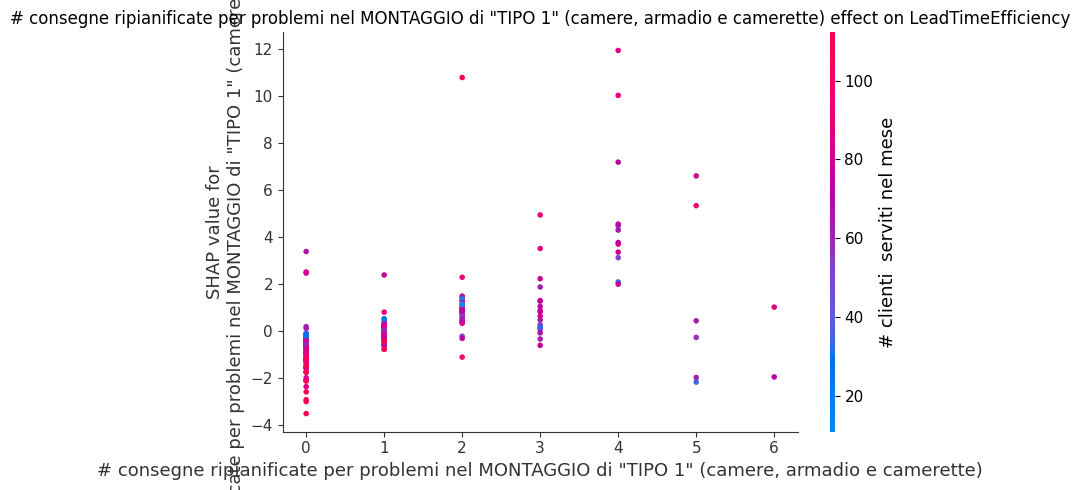

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import shap
import matplotlib.pyplot as plt

# --- CRITICAL CHANGES ---
# 1. Use ONLY raw features as inputs
# 2. Exclude ALL KPIs from model inputs
# 3. Validate feature independence

# ========================
# DATA PREPARATION
# ========================
def validate_features(df, key_kpis):
    """Ensure no KPI columns are accidentally used as features"""
    kpi_in_features = set(key_kpis) & set(df.columns)
    if kpi_in_features:
        raise ValueError(f"Data leakage! KPIs found in features: {kpi_in_features}")

# Key KPIs to explain (targets only)
key_kpis = ['LeadTimeEfficiency', 'PercentualeConsegneRiprogrammate', 'RitardoMedioConsegna']

# Exclude ALL KPIs and metadata from features
exclude_cols = key_kpis + [
    'Id', 'Mese', 'Id Equipaggio', 'UPL', 'Classe', 
    'Valore medio della merce consegnata in un giro [€/giro]',
    '# giorni lavorati nel mese', '# clienti serviti nel mese',
    'Delta (orario di fine montaggio EFFETTIVO - orario di fine montaggio CONCORDATO) [min]',
    '# consegne ripianificate per problemi nel TRASPORTO',
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 1"',
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 2"',
    '# consegne ripianificate per problemi nel MONTAGGIO di "TIPO 3"',
    '# consegne ripianificate per CAUSE LATO CLIENTE FINALE',
    'Unnamed: 14'
]

# Get raw features (only numeric non-KPI columns)
raw_features = [col for col in df.columns 
                if col not in exclude_cols 
                and pd.api.types.is_numeric_dtype(df[col])]

# Clean data
df_clean = df.dropna(subset=key_kpis + raw_features).copy()

# Validate no KPIs in features
validate_features(df_clean[raw_features], key_kpis)

# ========================
# SHAP ANALYSIS PER KPI
# ========================
shap_values_dict = {}

for kpi in key_kpis:
    print(f"\n=== Processing {kpi} ===")
    
    X = df_clean[raw_features]
    y = df_clean[kpi]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train model
    model = GradientBoostingRegressor(
        n_estimators=100, 
        random_state=42,
        max_depth=5  # Prevent overfitting
    )
    model.fit(X_train, y_train)
    
    # Explain with SHAP
    explainer = shap.TreeExplainer(model)  # More efficient for trees
    shap_values = explainer.shap_values(X_test)
    
    # Store results
    shap_values_dict[kpi] = {
        'model': model,
        'shap_values': shap_values,
        'X_test': X_test,
        'y_test': y_test,
        'explainer': explainer
    }
    
    # Evaluate model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"R² Train: {train_score:.3f}, R² Test: {test_score:.3f}")

# ========================
# VISUALIZATION & ANALYSIS
# ========================
# 1. Summary plots showing feature importance
for kpi in key_kpis:
    data = shap_values_dict[kpi]
    print(f"\nSHAP Summary for {kpi}:")
    shap.summary_plot(
        data['shap_values'], 
        data['X_test'],
        feature_names=raw_features,
        show=False
    )
    plt.title(f"Feature Impact on {kpi}")
    plt.tight_layout()
    plt.savefig(f"{kpi}_shap_summary.png", dpi=300)
    plt.close()

# 2. Calculate KPI-level importance
print("\n=== KPI Importance Breakdown ===")
kpi_importance = {}

for kpi in key_kpis:
    data = shap_values_dict[kpi]
    
    # Calculate mean absolute SHAP per feature
    mean_abs_shap = pd.Series(
        np.abs(data['shap_values']).mean(axis=0),
        index=raw_features
    ).sort_values(ascending=False)
    
    # Store sorted importance
    kpi_importance[kpi] = mean_abs_shap
    
    # Print top drivers
    print(f"\nTop drivers for {kpi}:")
    print(mean_abs_shap.head(10))

# 3. Dependence plots for key drivers
for kpi in key_kpis:
    data = shap_values_dict[kpi]
    mean_abs_shap = kpi_importance[kpi]
    
    # Plot top 3 drivers
    for feature in mean_abs_shap.index[:3]:
        print(f"\nDependence plot: {feature} vs {kpi}")
        shap.dependence_plot(
            feature,
            data['shap_values'],
            data['X_test'],
            feature_names=raw_features,
            show=False
        )
        plt.title(f"{feature} effect on {kpi}")
        plt.tight_layout()
        plt.savefig(f"{kpi}_{feature}_dependence.png", dpi=300)
        plt.close()

# ========================
# KPI IMPORTANCE AGGREGATION
# ========================
print("\n=== Final KPI Importance ===")

# Aggregate raw features to KPIs (requires domain knowledge)
# Example mapping - ADJUST BASED ON YOUR DATA STRUCTURE
feature_to_kpi_group = {
    'TotalShipments': 'DeliveryVolume',
    'TruckCapacityUtilization': 'ResourceEfficiency',
    # ... add all your raw features to KPI groups
}

# Calculate grouped importance
kpi_group_importance = {kpi: {} for kpi in key_kpis}

for target_kpi in key_kpis:
    mean_abs_shap = kpi_importance[target_kpi]
    
    for feature, importance in mean_abs_shap.items():
        group = feature_to_kpi_group.get(feature, "Ungrouped")
        kpi_group_importance[target_kpi].setdefault(group, 0)
        kpi_group_importance[target_kpi][group] += importance

    # Convert to percentages
    total = sum(kpi_group_importance[target_kpi].values())
    for group in kpi_group_importance[target_kpi]:
        kpi_group_importance[target_kpi][group] /= total

    print(f"\n{target_kpi} Driver Groups:")
    for group, pct in sorted(kpi_group_importance[target_kpi].items(), 
                             key=lambda x: x[1], 
                             reverse=True):
        print(f"- {group}: {pct:.1%}")